# **<span style="color:CadetBlue;"> Proyecto ML: "Employee Absenteeism at Work" </span>**

El absentismo laboral es un problema común en las organizaciones y tiene un impacto directo en la productividad, la planificación operativa y el clima laboral. Comprender y anticipar los patrones de ausencia puede ayudar a la empresa a diseñar estrategias más eficaces de gestión del talento, prevención de ausencias y promoción del bienestar laboral.

El objetivo de este proyecto es predecir si un empleado se ausentará del trabajo (o clasificar el tipo o nivel de absentismo) en función de sus características personales y laborales. A través de un enfoque de aprendizaje automático supervisado, se busca detectar patrones de comportamiento asociados al absentismo, con el fin de anticipar posibles casos y mejorar la toma de decisiones.

Entre las preguntas que se pretende responder se encuentran:

¿Qué variables personales o laborales están más relacionadas con el absentismo?

¿Es posible predecir si un empleado faltará al trabajo en función de su perfil?

Este análisis se basa en el dataset [“Absenteeism at Work”](https://archive.ics.uci.edu/dataset/445/absenteeism+at+work), que contiene registros de ausencias de empleados de una empresa en Brasil, junto con información médica, personal y laboral relevante.

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import bootcampviztools as bt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, RobustScaler

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

## 1. Entender el problema

El dataset de ´Absenteeism at Work´ contiene información sobre empleados, factores sociales y laborales, y la cantidad de horas que estuvieron ausentes del trabajo.

Es un problema supervisado pues tiene la variable target **Absenteeism time in hours**. 

Al ser un modelo de clasificación, las métricas son:

* Accuracy
* Precision
* Recall


## 2. Carga de datos

In [2]:
df = pd.read_csv("../data_sample/Absenteeism_at_work.csv", sep=";")

In [3]:
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

*Todas las columnas son numéricas y no hay nulos*

In [5]:
target = "Absenteeism time in hours"

In [6]:
df.nunique()

ID                                 36
Reason for absence                 28
Month of absence                   13
Day of the week                     5
Seasons                             4
Transportation expense             24
Distance from Residence to Work    25
Service time                       18
Age                                22
Work load Average/day              38
Hit target                         13
Disciplinary failure                2
Education                           4
Son                                 5
Social drinker                      2
Social smoker                       2
Pet                                 6
Weight                             26
Height                             14
Body mass index                    17
Absenteeism time in hours          19
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,740.0,18.017568,11.021247,1.000,9.000,18.000,28.000,36.000
Reason for absence,740.0,19.216216,8.433406,0.000,13.000,23.000,26.000,28.000
Month of absence,740.0,6.324324,3.436287,0.000,3.000,6.000,9.000,12.000
Day of the week,740.0,3.914865,1.421675,2.000,3.000,4.000,5.000,6.000
Seasons,740.0,2.544595,1.111831,1.000,2.000,3.000,4.000,4.000
Transportation expense,740.0,221.329730,66.952223,118.000,179.000,225.000,260.000,388.000
Distance from Residence to Work,740.0,29.631081,14.836788,5.000,16.000,26.000,50.000,52.000
Service time,740.0,12.554054,4.384873,1.000,9.000,13.000,16.000,29.000
Age,740.0,36.450000,6.478772,27.000,31.000,37.000,40.000,58.000
Work load Average/day,740.0,271.490235,39.058116,205.917,244.387,264.249,294.217,378.884


Transformaciones para que sea un problema de clasificación

In [8]:
df["absent"] = df["Absenteeism time in hours"].apply(lambda x: 1 if x >= 3 else 0)

In [9]:
df['Education'] = df['Education'].apply(lambda x: 2 if x > 1 else 1)

In [10]:
df['Has_pet'] = df['Pet'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
df["Has_son"] =df["Son"].apply(lambda x: 1 if x > 0 else 0)

In [12]:
df = df.drop(columns= ["ID", "Height", "Weight", "Disciplinary failure", "Pet", "Son", "Absenteeism time in hours"])

In [13]:
target="absent"

## 3. Train y test

In [14]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## 4. MiniEDA

**Target**

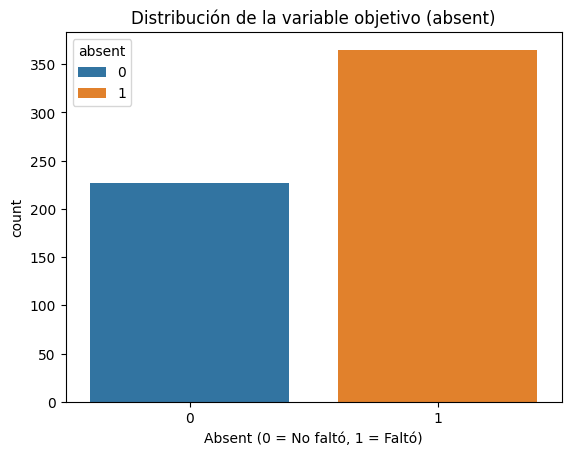

In [15]:
sns.countplot(x="absent", data=train_set, hue="absent")
plt.title("Distribución de la variable objetivo (absent)")
plt.xlabel("Absent (0 = No faltó, 1 = Faltó)")
plt.show()

In [16]:
corr = np.abs(train_set.corr()[target]).sort_values(ascending=True)
print(corr)

Work load Average/day              0.000389
Social smoker                      0.003814
Body mass index                    0.026319
Has_pet                            0.031090
Education                          0.032121
Hit target                         0.032144
Day of the week                    0.039385
Month of absence                   0.045736
Service time                       0.055615
Has_son                            0.058398
Seasons                            0.060653
Age                                0.083560
Reason for absence                 0.095888
Social drinker                     0.102513
Distance from Residence to Work    0.109384
Transportation expense             0.183896
absent                             1.000000
Name: absent, dtype: float64


*Las correlaciones son muy bajas*

**Comprensión variables**

Feature | Tipo | Descripción |
| ------ | ---- | -------- |
Reason for absence|	Categórica nominal|	Código de razón médica/social de la ausencia (0–28).
Month of absence|	Categórica nominal	|Mes en que ocurrió la ausencia (1 = enero, ..., 12 = diciembre).
Day of the week|	Categórica nominal	|Día de la semana (2 = lunes, 3 = martes, 4 = miércoles, 5 = jueves, 6 = viernes).
Seasons	| Categórica nominal |	Estación del año (1 = verano, ..., 4 = primavera).
Transportation expense |	Numérica continua	|Gasto mensual en transporte (en euros).
Distance from Residence to Work |	Numérica continua	|Distancia desde la residencia al trabajo (en km).
Service time|	Numérica discreta|	Años de antigüedad en la empresa.
Age	|Numérica continua|	Edad del empleado (en años).
Work load Average/day |	Numérica continua	|Carga de trabajo promedio por día (en minutos). 
Hit target |	Numérica discreta |	Porcentaje de cumplimiento de objetivos.
Disciplinary failure |	Categórica binaria |	0 = no, 1 = sí (fallos disciplinarios previos).
Education |	Categórica ordinal |	Nivel educativo (1 = instituto, 2 = graduado, 3 = postgrado, 4 = doctorado).
Son |	Numérica discreta|	Número de hijos. (*tratar como categórica)
Social drinker|	Categórica binaria |	0 = no, 1 = sí (consume alcohol socialmente).
Social smoker |	Categórica binaria |	0 = no, 1 = sí (fuma en contexto social).
Pet	| Numérica discreta |	Número de mascotas. (*tratar como categórica)
Weight |	Numérica continua |	Peso del empleado (en kg).
Height |	Numérica continua	| Altura del empleado (en cm).
Body mass index (BMI)|	Numérica continua|	Índice de masa corporal. Calculado a partir de peso y altura.
Absenteeism time in hours|	Numérica continua (target)|	Total de horas de ausencia laboral.

Categóricas 
* Reason for absence 
* Month of absence  
* Day of the week 
* Disciplinary failure
* Education 
* Social drinker 
* Social smoker 
* Pet
* Son

Numéricas
* Transportation expense
* Distance from Residence to Work
* Service time
* Age
* Work load Average/day
* Hit target
* Weight
* Height
* Body mass index

In [17]:
features_cat = [ "Reason for absence", "Month of absence", "Day of the week", "Education", "Social drinker", "Social smoker", "Has_pet", "Son_cat"]
features_num = ["Transportation expense", "Distance from Residence to Work", "Service time", "Age", "Work load Average/day ", "Hit target", "Body mass index"]

Análisis visual

**NUMÉRICAS**

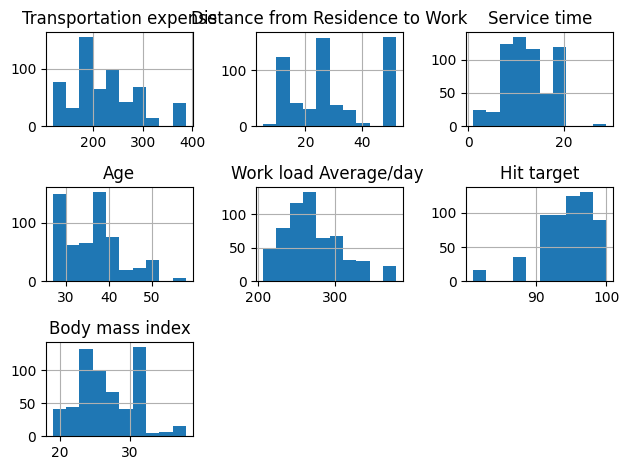

In [18]:
train_set[features_num].hist()
plt.tight_layout()

*Transformación de features*

*Aplicaremos transformaciones:*
- logaritmo: `Transportation expense`, `Work load Average/day`, `Body mass index`
- escalado estándar: `Distance from Residence to Work`, `Service time`, `Age`, `Hit target`

**CATEGÓRICAS**

One hot encoding

In [19]:
train_set["Month of absence"].value_counts()

Month of absence
3     77
2     61
10    53
7     52
11    45
9     45
4     45
6     44
8     43
5     42
12    42
1     40
0      3
Name: count, dtype: int64

In [20]:
train_set["Day of the week"].value_counts()

Day of the week
2    128
3    123
6    123
4    112
5    106
Name: count, dtype: int64

In [21]:
razones = {
    0:"UNK", 1:'Infectious', 2:'Neoplasms', 3:'Blood', 4:'Endocrine',
    5:'Mental', 6:'Nervous_system', 7:'Eye', 8:'Ear',
    9:'Circulatory', 10:'Respiratory', 11:'Digestive', 12:'Skin',
    13:'Musculoskeletal', 14:'Genitourinary', 15: 'Pregnancy', 16:'Perinatal', 
    17:'Congenital', 18:'Symptons', 19:'Injuries', 20:'External causes', 
    21:'healthstatus', 22:'Follow-up', 23:'Consultation', 24:'Blood-donation',
    25:'Lab', 26:'Unjustified', 27:'Physio', 28:'Dentist'
}

meses = {
    1: 'Jan', 2: 'Febr', 3: 'Mar', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', 0: 'UNK'
}

dias = {
    2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday'
}

estaciones = {
    1: 'Summer', 2: 'Autumn', 3: 'Winter', 4: 'Spring'
}

train_set["Reason for absence"] = train_set["Reason for absence"].map(razones)
train_set['Month of absence'] = train_set['Month of absence'].map(meses)
train_set['Day of the week'] = train_set['Day of the week'].map(dias)
train_set['Seasons'] = train_set['Seasons'].map(estaciones)

test_set["Reason for absence"] = test_set["Reason for absence"].map(razones)
test_set['Month of absence'] = test_set['Month of absence'].map(meses)
test_set['Day of the week'] = test_set['Day of the week'].map(dias)
test_set['Seasons'] = test_set['Seasons'].map(estaciones)

In [22]:
cat_feats= ["Reason for absence", "Month of absence", "Day of the week", "Seasons"]

train_cat = pd.get_dummies(train_set[cat_feats], drop_first=True)
test_cat = pd.get_dummies(test_set[cat_feats], drop_first=True)

In [23]:
# Alinear columnas para evitar errores
train_cat, test_cat = train_cat.align(test_cat, join='left', axis=1, fill_value=0)

In [24]:
X_train = pd.concat([train_set[features_num], train_cat], axis=1)
X_test = pd.concat([test_set[features_num], test_cat], axis=1)

Escalar numéricas

In [25]:
# Transformación logarítmica para las más sesgadas
log_feats = ['Transportation expense', 'Work load Average/day ', 'Body mass index']

log1p_transformer = FunctionTransformer(np.log1p)
X_train_log = log1p_transformer.fit_transform(train_set[log_feats])
X_test_log = log1p_transformer.transform(test_set[log_feats])

robust_scaler = RobustScaler()
X_train_log_scaled = robust_scaler.fit_transform(X_train_log)
X_test_log_scaled = robust_scaler.transform(X_test_log)

# Para las demás
std_feats = ['Distance from Residence to Work', 'Service time', 'Age', 'Hit target']

standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(train_set[std_feats])
X_test_std = standard_scaler.transform(test_set[std_feats])

In [26]:
X_train_transformed_num = pd.DataFrame(
    np.hstack([X_train_log_scaled, X_train_std]),
    columns=log_feats + std_feats,
    index=train_set.index
)

X_test_transformed_num = pd.DataFrame(
    np.hstack([X_test_log_scaled, X_test_std]),
    columns=log_feats + std_feats,
    index=test_set.index)

In [27]:
X_train_transformed = pd.concat([X_train_transformed_num, train_cat], axis=1)
X_test_transformed = pd.concat([X_test_transformed_num, test_cat], axis=1)

In [28]:
y_train = train_set[target]
y_test = test_set[target]

**MODELOS**

In [29]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [30]:
modelos_escalados = {
    "Logistic": LogisticRegression(max_iter=2000, class_weight="balanced")
}

modelos_no_escalados = {
    "RandomF": RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced"),
    "XGB": XGBClassifier(max_depth=10, random_state=42, n_jobs=-1),
    "LGB": LGBMClassifier(max_depth=10, random_state=42, verbose=-100, class_weight="balanced", n_jobs=-1)
}


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def evaluate_model(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensibilidad = tp / (tp + fn)
    especificidad = tn / (tn + fp)
    precision = tp / (tp + fp)
    print(f"✔️ Sensibilidad: {sensibilidad:.2f}")
    print(f"✔️ Especificidad: {especificidad:.2f}")
    print(f"✔️ Precisión: {precision:.2f}")

# Ejemplo para Random Forest
for nombre, model in modelos_escalados.items():
    model.fit(X_train_transformed, y_train)      
    print("Modelo:", nombre, "(con datos escalados)")
    pred_train = model.predict(X_train_transformed)
    pred_test = model.predict(X_test_transformed)
    evaluate_model(y_test, pred_test)
    print(classification_report(y_test, pred_test))


for nombre, model in modelos_no_escalados.items():
    model.fit(X_train, y_train)  # sin escalar
    print("Modelo:", nombre, "(sin datos escalados)")
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    evaluate_model(y_test, pred_test)
    print(classification_report(y_test, pred_test))

Modelo: Logistic (con datos escalados)
✔️ Sensibilidad: 0.72
✔️ Especificidad: 0.73
✔️ Precisión: 0.78
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        62
           1       0.78      0.72      0.75        86

    accuracy                           0.72       148
   macro avg       0.72      0.72      0.72       148
weighted avg       0.73      0.72      0.72       148

Modelo: RandomF (sin datos escalados)
✔️ Sensibilidad: 0.87
✔️ Especificidad: 0.60
✔️ Precisión: 0.75
              precision    recall  f1-score   support

           0       0.77      0.60      0.67        62
           1       0.75      0.87      0.81        86

    accuracy                           0.76       148
   macro avg       0.76      0.73      0.74       148
weighted avg       0.76      0.76      0.75       148

Modelo: XGB (sin datos escalados)
✔️ Sensibilidad: 0.88
✔️ Especificidad: 0.60
✔️ Precisión: 0.75
              precision    recall  f1-score

Si la empresa quiere detectar todos los posibles ausentistas (aunque dé falsos positivos) → prioriza sensibilidad → XGBoost (0.88) o Random Forest (0.87)

Si buscas un modelo más equilibrado entre falsos positivos y negativos, LightGBM gana en conjunto.

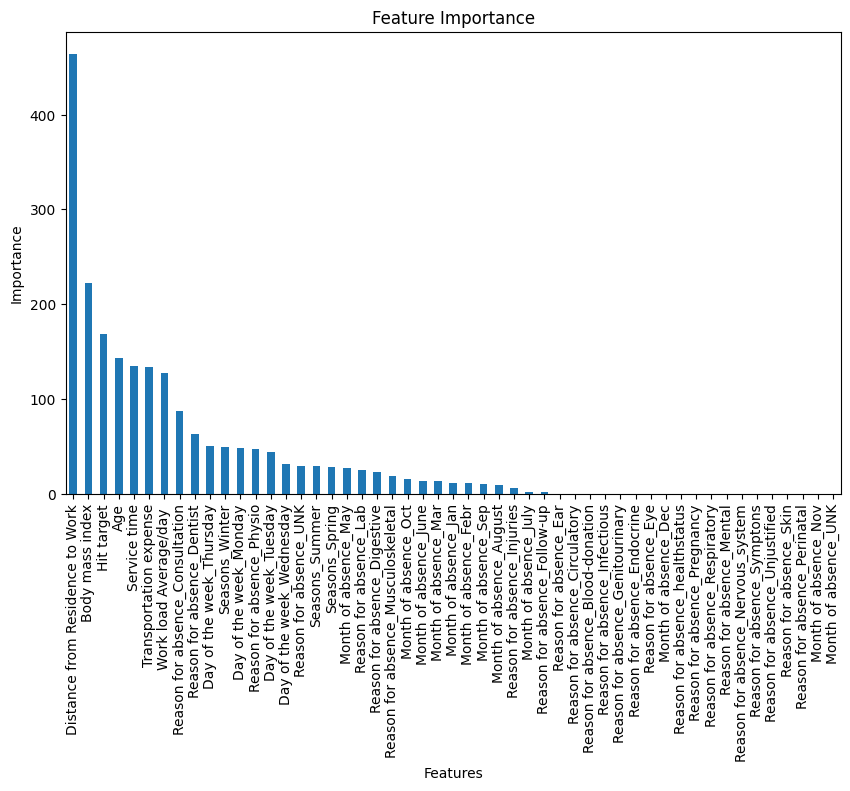

In [31]:
feature_names = X_train.columns  

lgb= LGBMClassifier(max_depth=10, random_state=42, verbose=-100, class_weight="balanced", n_jobs=-1)
lgb.fit(X_train_transformed, y_train)

importances = lgb.feature_importances_

# Crear DataFrame ordenado
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
feat_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [32]:
feat_importances

Distance from Residence to Work       464
Body mass index                       222
Hit target                            169
Age                                   143
Service time                          135
Transportation expense                134
Work load Average/day                 128
Reason for absence_Consultation        88
Reason for absence_Dentist             63
Day of the week_Thursday               51
Seasons_Winter                         50
Day of the week_Monday                 48
Reason for absence_Physio              47
Day of the week_Tuesday                44
Day of the week_Wednesday              32
Reason for absence_UNK                 30
Seasons_Summer                         30
Seasons_Spring                         28
Month of absence_May                   27
Reason for absence_Lab                 25
Reason for absence_Digestive           23
Reason for absence_Musculoskeletal     19
Month of absence_Oct                   16
Month of absence_June             

In [33]:
#Logistic
logreg = LogisticRegression(max_iter=1000, random_state=42)
param_logreg = {"penalty": ["l1","l2"], # Regularizaciones L1 y L2.
                "C": [0.1, 0.5, 1.0, 5.0], 
                "max_iter": [50,100,500],
                "solver": ["liblinear"]  # Suele ser el más rápido
                }

grid_logreg = GridSearchCV(logreg, param_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1.0, 5.0], 'max_iter': [50, 100, 500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [34]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
param_rf = {
    'n_estimators': [100, 200, 400],
    "max_depth": [3,4,5,6,10,15,17],
    'min_samples_leaf': [1,10,20,100],
    'class_weight':['balanced', None],
    "max_features": ["sqrt", 3, 4]
}
grid_rf = GridSearchCV(rf, param_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 4, 5, 6, 10, 15, 17],
                         'max_features': ['sqrt', 3, 4],
                         'min_samples_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [35]:
#XGB
xgb = XGBClassifier(max_depth=5, random_state=42)
param_xgb = {
    'n_estimators': [100, 200, 400],
    'eta': [0.1, 0.3, 0.6, 1],
    'max_depth': [1, 6, 10, None],
    'min_child_weight': [1,10,20,100],
    'colsample_bytree': [0.5,1]
}
grid_xgb = GridSearchCV(xgb, param_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1],
                         'eta': [0.1, 0.3, 0.6, 1],
                         'max_depth': [1, 6, 10, None],
                         'min_child_weight': [1, 10, 20, 100],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [36]:
#LGB
lgbm = LGBMClassifier(random_state=42) 
param_lgbm = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.1, 0.3, 0.6, 1], 
    'max_depth': [1, 6, 10, -1],  
    'min_child_samples': [1, 10, 20, 100], 
    'scale_pos_weight': [
        len(df[df[target]==0]) / len(df[df[target]==1]),
        1],
    'colsample_bytree': [0.5, 1]
}
grid_lgbm = GridSearchCV(lgbm, param_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1],
                         'learning_rate': [0.1, 0.3, 0.6, 1],
                         'max_depth': [1, 6, 10, -1],
                         'min_child_samples': [1, 10, 20, 100],
                         'n_estimators': [100, 200, 400],
                         'scale_pos_weight': [0.6407982261640798, 1]},
             scoring='accuracy')

In [37]:
from sklearn.metrics import accuracy_score

# Evaluación
models_con = {
    "LogisticR": grid_logreg}

models_sin={
    "RandomForest": grid_rf,
    "LightGBM": grid_lgbm,
    "XGBoost": grid_xgb
}

for name, model in models_con.items():
    acc = accuracy_score(y_test, model.predict(X_test_transformed))
    print(f"{name} - Best Params: {model.best_params_} | CV Score: {model.best_score_:.4f} | Test Accuracy: {acc:.4f}")
   
for name, model in models_sin.items():
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name} - Best Params: {model.best_params_} | CV Score: {model.best_score_:.4f} | Test Accuracy: {acc:.4f}")

LogisticR - Best Params: {'C': 1.0, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'} | CV Score: 0.7433 | Test Accuracy: 0.7297
RandomForest - Best Params: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} | CV Score: 0.7669 | Test Accuracy: 0.7568
LightGBM - Best Params: {'colsample_bytree': 0.5, 'learning_rate': 0.6, 'max_depth': 1, 'min_child_samples': 10, 'n_estimators': 100, 'scale_pos_weight': 1} | CV Score: 0.7788 | Test Accuracy: 0.7432
XGBoost - Best Params: {'colsample_bytree': 0.5, 'eta': 1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100} | CV Score: 0.7855 | Test Accuracy: 0.7230


*El mejor modelo con los hiperparámetros ajustados es Random Forest, en este caso*